In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import procrustes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_images_160x320.npy')
true_landmarks = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_landmarks.npy')

CNN_Standard = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_full_augmentation.npy')
UNET_Standard = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_full_augmentation.npy')

metadata = pd.read_csv('/content/drive/MyDrive/Arlette/df_with_metadata.csv')

plot procrustes disparity

In [ ]:
# procrustes disparity per sample
def procrustes_disparity(X, Y):
    _, _, disparity = procrustes(X, Y)
    return disparity

def compute_samplewise_metrics(true, pred, width=320, height=160):
    n_samples = true.shape[0]
    mpe = np.zeros(n_samples)
    disp = np.zeros(n_samples)

    # scale to pixel
    true_scaled = true.copy()
    pred_scaled = pred.copy()
    true_scaled[...,0] *= width
    true_scaled[...,1] *= height
    pred_scaled[...,0] *= width
    pred_scaled[...,1] *= height

    for i in range(n_samples):
        mpe[i] = np.mean(np.sqrt(np.sum((true_scaled[i] - pred_scaled[i])**2, axis=1)))
        disp[i] = procrustes_disparity(true_scaled[i], pred_scaled[i])
    return disp, mpe   # x=disp, y=mpe

# outlier (3 sd)
def remove_outliers(x, y, n_std=3):
    mask = (np.abs(x - np.mean(x)) < n_std * np.std(x)) & \
           (np.abs(y - np.mean(y)) < n_std * np.std(y))
    return x[mask], y[mask], mask

# range filter 0.03
def range_filter(x, y, max_disp=0.03):
    mask = x <= max_disp
    return x[mask], y[mask], mask

# get data
true_landmarks = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_landmarks.npy')
CNN_preds = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_full_augmentation.npy')
UNET_preds = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_full_augmentation.npy')

# calculate MPE and disparity
disp_CNN, mpe_CNN = compute_samplewise_metrics(true_landmarks, CNN_preds)
disp_UNET, mpe_UNET = compute_samplewise_metrics(true_landmarks, UNET_preds)

# calculate regression and R²
def regression_results(x, y, label):
    # range filter
    x, y, _ = range_filter(x, y, max_disp=0.06)
    # remove outlier
    x_filt, y_filt, mask = remove_outliers(x, y, n_std=3)
    # regression
    model = LinearRegression().fit(x_filt.reshape(-1,1), y_filt)
    r2 = r2_score(y_filt, model.predict(x_filt.reshape(-1,1)))

    print(f"{label}: n={len(x)} nach Range-Filter, n={len(x_filt)} nach Outlier Removal, R²={r2:.3f}")
    return model, x_filt, y_filt

# CNN
model_CNN, xC, yC = regression_results(disp_CNN, mpe_CNN, "CNN")
# UNet
model_UNET, xU, yU = regression_results(disp_UNET, mpe_UNET, "UNet")

CNN: n=987 nach Range-Filter, n=965 nach Outlier Removal, R²=0.193
UNet: n=985 nach Range-Filter, n=963 nach Outlier Removal, R²=0.690


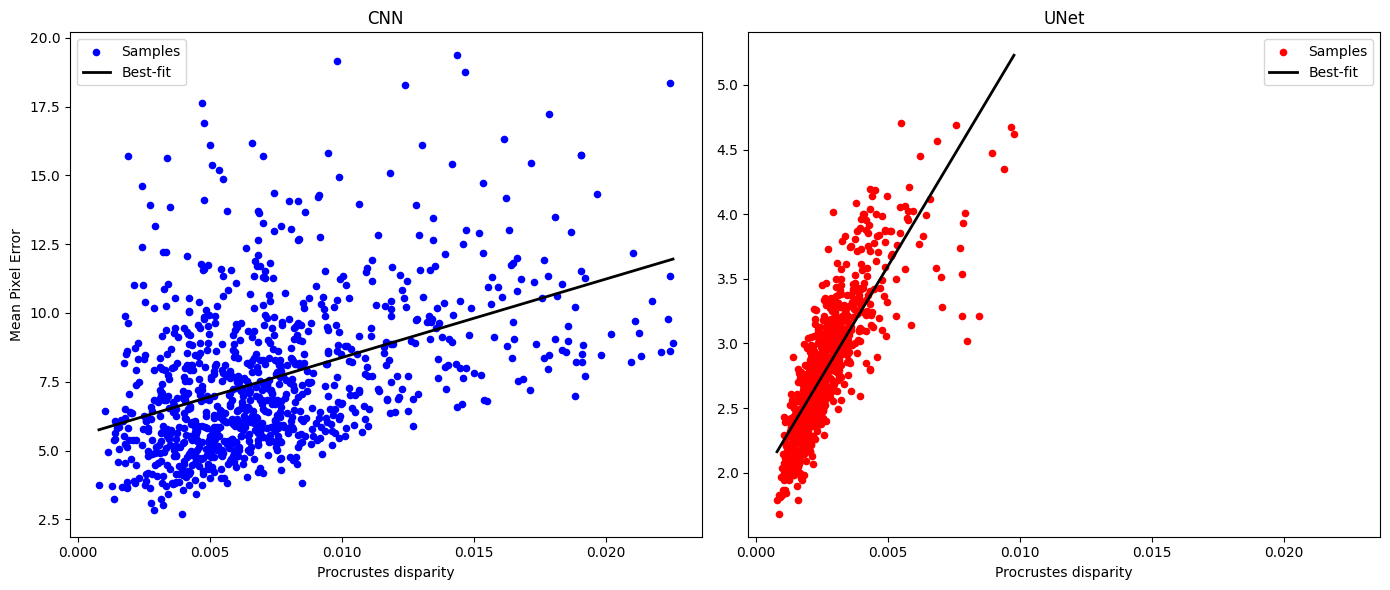

In [ ]:
def procrustes_disparity(X, Y):
    _, _, disparity = procrustes(X, Y)
    return disparity

def compute_samplewise_metrics(true, pred, width=320, height=160):
    n_samples = true.shape[0]
    mpe = np.zeros(n_samples)
    disp = np.zeros(n_samples)

    true_scaled = true.copy()
    pred_scaled = pred.copy()
    true_scaled[...,0] *= width
    true_scaled[...,1] *= height
    pred_scaled[...,0] *= width
    pred_scaled[...,1] *= height

    for i in range(n_samples):
        mpe[i] = np.mean(np.sqrt(np.sum((true_scaled[i] - pred_scaled[i])**2, axis=1)))
        disp[i] = procrustes_disparity(true_scaled[i], pred_scaled[i])
    return disp, mpe

def remove_outliers(x, y, n_std=3):
    mask = (np.abs(x - np.mean(x)) < n_std * np.std(x)) & \
           (np.abs(y - np.mean(y)) < n_std * np.std(y))
    return x[mask], y[mask], mask

def range_filter(x, y, max_disp=0.06):
    mask = x <= max_disp
    return x[mask], y[mask], mask

def regression_with_ci(x, y, n_std=3, max_disp=0.06):
    x, y, _ = range_filter(x, y, max_disp)
    x_filt, y_filt, _ = remove_outliers(x, y, n_std)

    # stats for ci
    X_sm = sm.add_constant(x_filt)
    model = sm.OLS(y_filt, X_sm).fit()
    pred = model.get_prediction(X_sm)
    pred_summary = pred.summary_frame(alpha=0.05)  # 95% CI
    return x_filt, y_filt, model, pred_summary

# data
true_landmarks = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_landmarks.npy')
CNN_preds = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_full_augmentation.npy')
UNET_preds = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_full_augmentation.npy')

disp_CNN, mpe_CNN = compute_samplewise_metrics(true_landmarks, CNN_preds)
disp_UNET, mpe_UNET = compute_samplewise_metrics(true_landmarks, UNET_preds)

xC, yC, model_CNN, ci_C = regression_with_ci(disp_CNN, mpe_CNN)
xU, yU, model_UNET, ci_U = regression_with_ci(disp_UNET, mpe_UNET)

# plot
fig, ax = plt.subplots(1,2, figsize=(14,6), sharex=True, sharey=False)

# CNN
ax[0].scatter(xC, yC, color='blue', alpha=1, s=20, label="Samples")
sort_idx_C = np.argsort(xC)
ax[0].plot(xC[sort_idx_C], model_CNN.predict(sm.add_constant(xC[sort_idx_C])), color='black', lw=2, label="Best-fit")
ax[0].set_title("CNN")
ax[0].set_xlabel("Procrustes disparity")
ax[0].set_ylabel("Mean Pixel Error")
ax[0].legend()

# UNet
ax[1].scatter(xU, yU, color='red', alpha=1, s=20, label="Samples")
sort_idx_U = np.argsort(xU)
ax[1].plot(xU[sort_idx_U], model_UNET.predict(sm.add_constant(xU[sort_idx_U])), color='black', lw=2, label="Best-fit")
ax[1].set_title("UNet")
ax[1].set_xlabel("Procrustes disparity")
ax[1].legend()

plt.tight_layout()
plt.show()

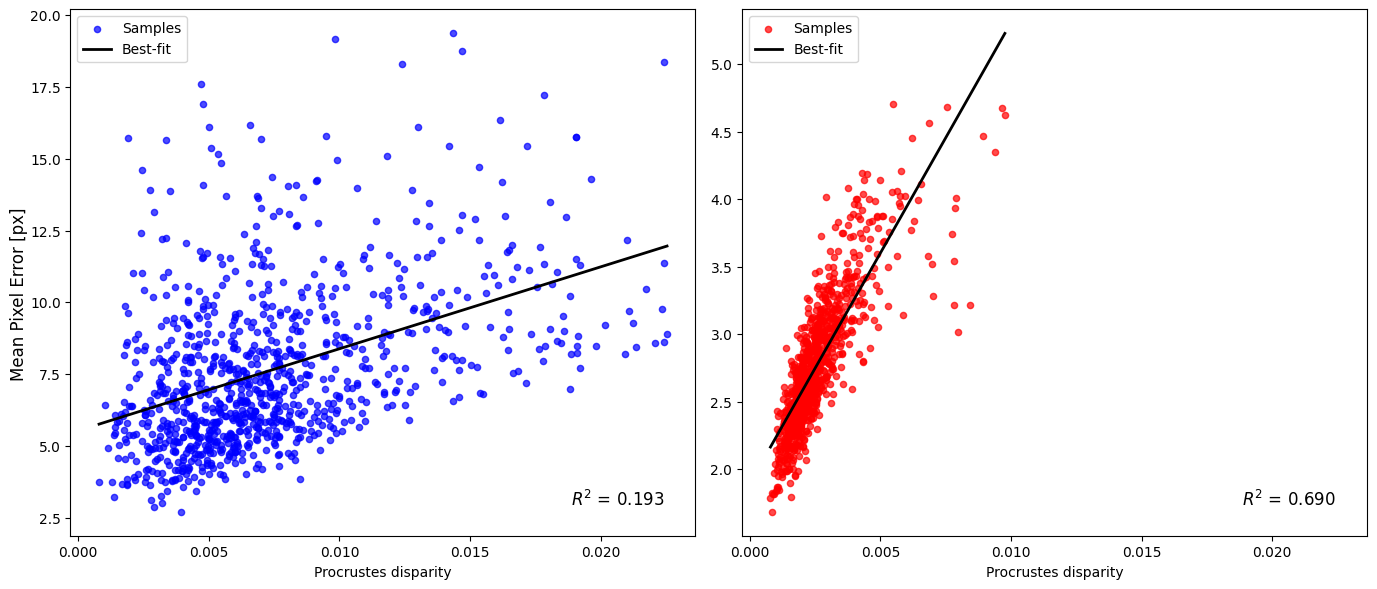

In [ ]:
# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=False)

# CNN
ax[0].scatter(xC, yC, color='blue', alpha=0.7, s=20, label="Samples")
sort_idx_C = np.argsort(xC)
y_pred_C = model_CNN.predict(sm.add_constant(xC[sort_idx_C]))
ax[0].plot(xC[sort_idx_C], y_pred_C, color='black', lw=2, label="Best-fit")
r2_C = r2_score(yC, model_CNN.predict(sm.add_constant(xC)))
ax[0].text(0.95, 0.05, f"$R^2$ = {r2_C:.3f}", transform=ax[0].transAxes,
           verticalalignment='bottom', horizontalalignment='right', fontsize=12)
ax[0].set_xlabel("Procrustes disparity")
ax[0].legend(loc='upper left')

# UNet
ax[1].scatter(xU, yU, color='red', alpha=0.7, s=20, label="Samples")
sort_idx_U = np.argsort(xU)
y_pred_U = model_UNET.predict(sm.add_constant(xU[sort_idx_U]))
ax[1].plot(xU[sort_idx_U], y_pred_U, color='black', lw=2, label="Best-fit")
r2_U = r2_score(yU, model_UNET.predict(sm.add_constant(xU)))
ax[1].text(0.95, 0.05, f"$R^2$ = {r2_U:.3f}", transform=ax[1].transAxes,
           verticalalignment='bottom', horizontalalignment='right', fontsize=12)
ax[1].set_xlabel("Procrustes disparity")
ax[1].legend(loc='upper left')

# Gemeinsame y-Achse (moderner Ansatz)
fig.supylabel("Mean Pixel Error [px]", fontsize=12)

plt.tight_layout()
plt.show()


procrustes alignment for standard experiment

In [ ]:
# procrustes alignment wihout scale
def procrustes_pixel(true_lms, pred_lms):
    # center mean
    true_centered = true_lms - np.mean(true_lms, axis=0)
    pred_centered = pred_lms - np.mean(pred_lms, axis=0)

    # calculate rotation
    U, _, Vt = np.linalg.svd(pred_centered.T @ true_centered)
    R = U @ Vt
    pred_aligned = pred_centered @ R

    # alignment to GT
    pred_aligned += np.mean(true_lms, axis=0)

    return pred_aligned

# land landmark
mean_GT = np.mean(true_landmarks, axis=0)
mean_CNN = np.mean([procrustes_pixel(true_landmarks[i], CNN_Standard[i]) for i in range(true_landmarks.shape[0])], axis=0)
mean_UNET = np.mean([procrustes_pixel(true_landmarks[i], UNET_Standard[i]) for i in range(true_landmarks.shape[0])], axis=0)

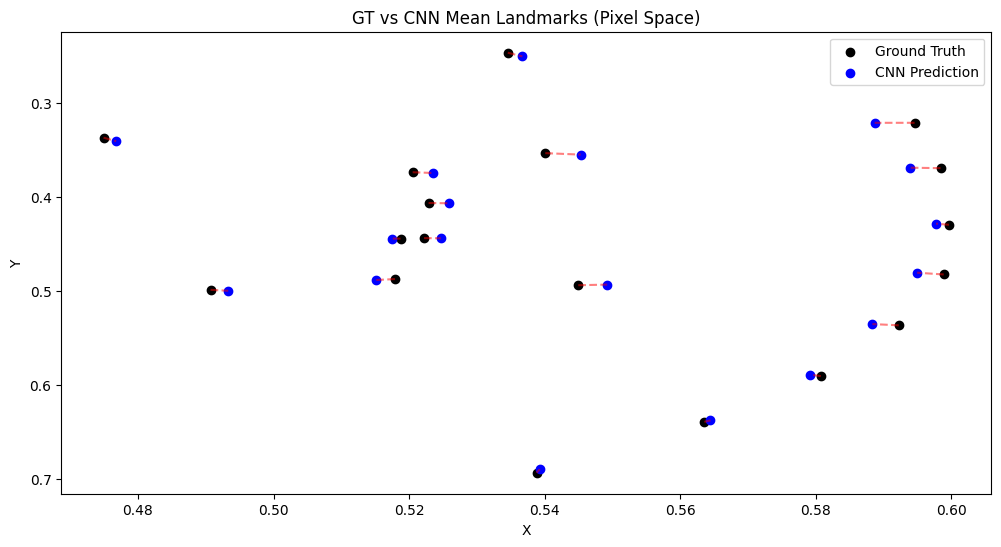

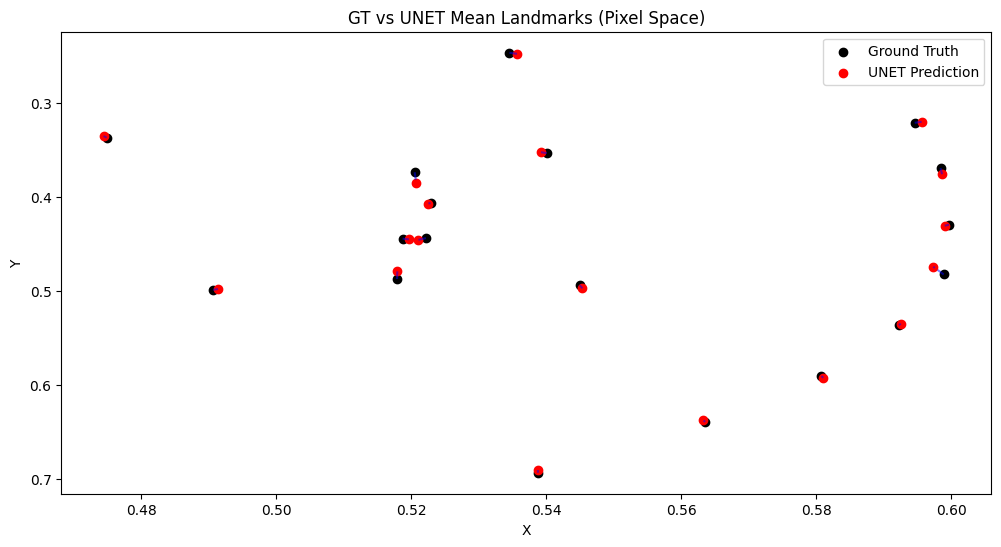

In [ ]:
# plot CNN
plt.figure(figsize=(12,6))
plt.scatter(mean_GT[:,0], mean_GT[:,1], c='black', label='Ground Truth')
plt.scatter(mean_CNN[:,0], mean_CNN[:,1], c='blue', label='CNN Prediction')
for i in range(mean_GT.shape[0]):
    plt.plot([mean_GT[i,0], mean_CNN[i,0]], [mean_GT[i,1], mean_CNN[i,1]], 'r--', alpha=0.5)
plt.gca().invert_yaxis()
plt.legend()
plt.title("GT vs CNN Mean Landmarks (Pixel Space)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# plot UNET
plt.figure(figsize=(12,6))
plt.scatter(mean_GT[:,0], mean_GT[:,1], c='black', label='Ground Truth')
plt.scatter(mean_UNET[:,0], mean_UNET[:,1], c='red', label='UNET Prediction')
for i in range(mean_GT.shape[0]):
    plt.plot([mean_GT[i,0], mean_UNET[i,0]], [mean_GT[i,1], mean_UNET[i,1]], 'b--', alpha=0.5)
plt.gca().invert_yaxis()
plt.legend()
plt.title("GT vs UNET Mean Landmarks (Pixel Space)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

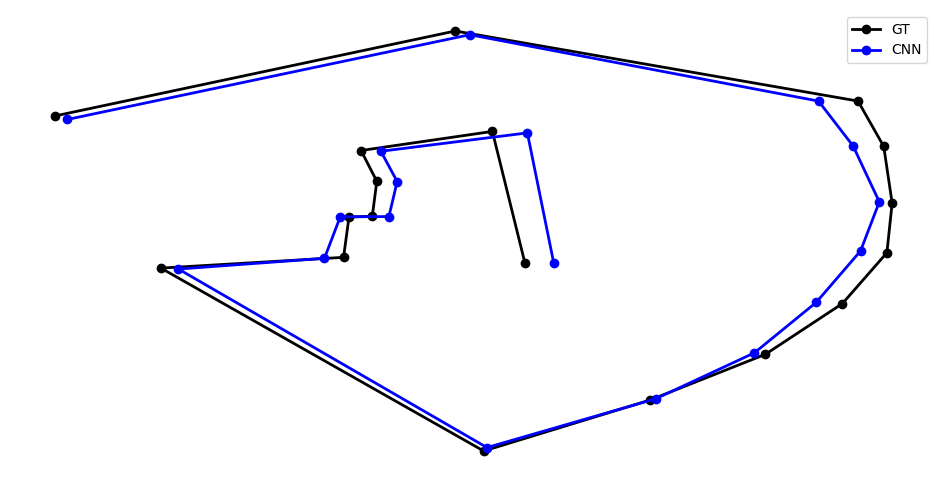

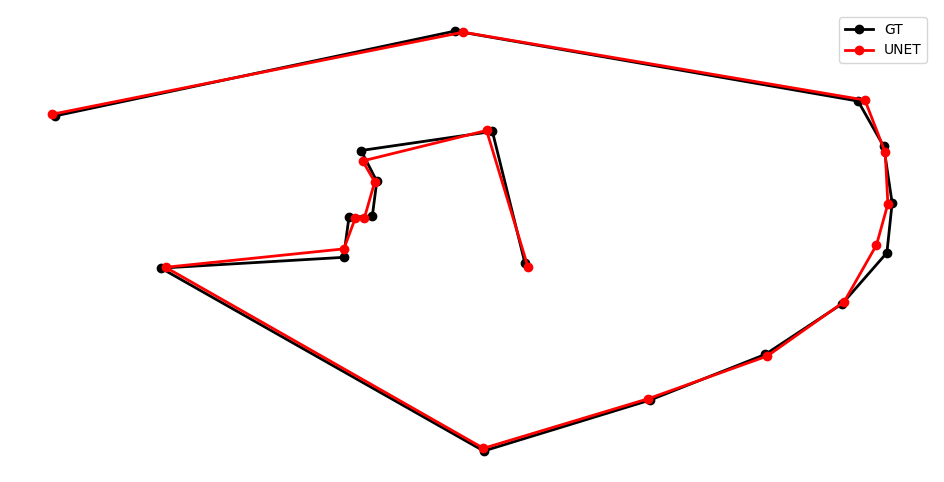

In [ ]:
def procrustes_pixel(true_lms, pred_lms):
    true_centered = true_lms - np.mean(true_lms, axis=0)
    pred_centered = pred_lms - np.mean(pred_lms, axis=0)
    U, _, Vt = np.linalg.svd(pred_centered.T @ true_centered)
    R = U @ Vt
    pred_aligned = pred_centered @ R
    pred_aligned += np.mean(true_lms, axis=0)
    return pred_aligned

# mean landmarks
mean_GT = np.mean(true_landmarks, axis=0)
mean_CNN = np.mean([procrustes_pixel(true_landmarks[i], CNN_Standard[i]) for i in range(true_landmarks.shape[0])], axis=0)
mean_UNET = np.mean([procrustes_pixel(true_landmarks[i], UNET_Standard[i]) for i in range(true_landmarks.shape[0])], axis=0)

# achses with padding
padding_x = 0.05 * (mean_GT[:,0].max() - mean_GT[:,0].min())
padding_y = 0.05 * (mean_GT[:,1].max() - mean_GT[:,1].min())

x_min = min(mean_GT[:,0].min(), mean_CNN[:,0].min(), mean_UNET[:,0].min()) - padding_x
x_max = max(mean_GT[:,0].max(), mean_CNN[:,0].max(), mean_UNET[:,0].max()) + padding_x
y_min = min(mean_GT[:,1].min(), mean_CNN[:,1].min(), mean_UNET[:,1].min()) - padding_y
y_max = max(mean_GT[:,1].max(), mean_CNN[:,1].max(), mean_UNET[:,1].max()) + padding_y

# plot CNN
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(mean_GT[:,0], mean_GT[:,1], '-o', color='black', lw=2, label='GT', markersize=6)
ax.plot(mean_CNN[:,0], mean_CNN[:,1], '-o', color='blue', lw=2, label='CNN', markersize=6)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.invert_yaxis()

# axis 1:2
ax.set_aspect((x_max - x_min) / ((y_max - y_min)*2))
ax.axis('off')
ax.legend()
plt.show()

# plot UNet
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(mean_GT[:,0], mean_GT[:,1], '-o', color='black', lw=2, label='GT', markersize=6)
ax.plot(mean_UNET[:,0], mean_UNET[:,1], '-o', color='red', lw=2, label='UNET', markersize=6)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.invert_yaxis()

ax.set_aspect((x_max - x_min) / ((y_max - y_min)*2))
ax.axis('off')
ax.legend()
plt.show()

alignments per landamark (mean over all samples)

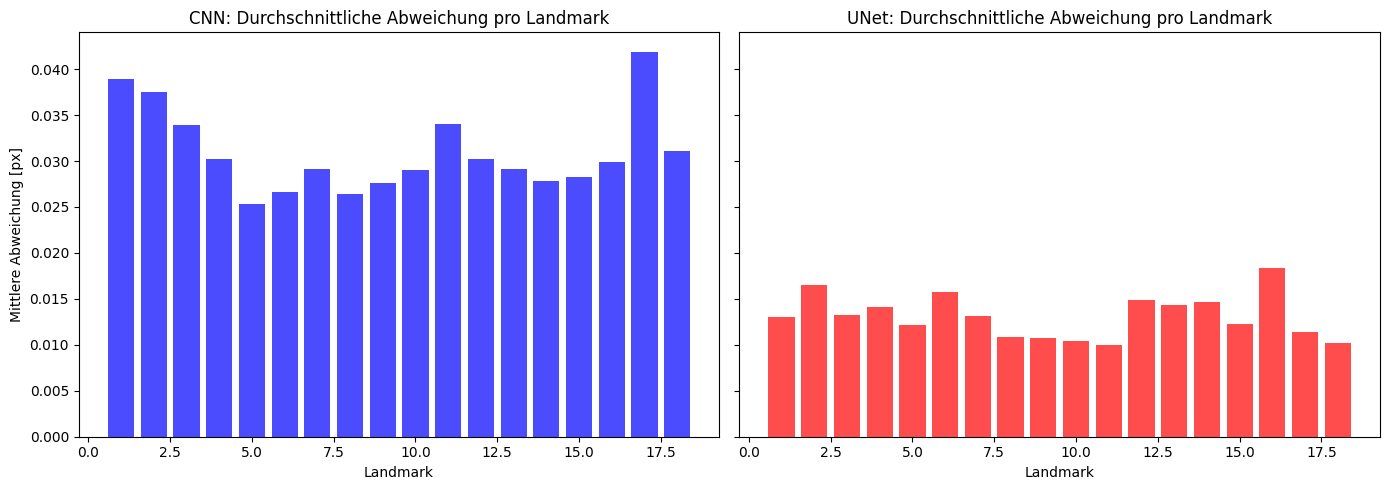

In [ ]:
# alignment per landmark
diff_CNN_all = np.mean(np.linalg.norm(CNN_preds - true_landmarks, axis=2), axis=0)
diff_UNET_all = np.mean(np.linalg.norm(UNET_preds - true_landmarks, axis=2), axis=0)

# landmark index
landmarks = np.arange(1, true_landmarks.shape[1]+1)

# barplot
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True)

ax[0].bar(landmarks, diff_CNN_all, color='blue', alpha=0.7)
ax[0].set_title("CNN: Durchschnittliche Abweichung pro Landmark")
ax[0].set_xlabel("Landmark")
ax[0].set_ylabel("Mittlere Abweichung [px]")

ax[1].bar(landmarks, diff_UNET_all, color='red', alpha=0.7)
ax[1].set_title("UNet: Durchschnittliche Abweichung pro Landmark")
ax[1].set_xlabel("Landmark")

plt.tight_layout()
plt.show()

sort from best so worst

In [ ]:
# sort CNN
sorted_idx_CNN = np.argsort(diff_CNN_all)
print("CNN: best → worst landmarks")
for idx in sorted_idx_CNN:
    print(f"Landmark {landmarks[idx]}: {diff_CNN_all[idx]:.4f} px")

# sort UNet
sorted_idx_UNET = np.argsort(diff_UNET_all)
print("\nUNet: best → worst landmarks")
for idx in sorted_idx_UNET:
    print(f"Landmark {landmarks[idx]}: {diff_UNET_all[idx]:.4f} px")

CNN: best → worst landmarks
Landmark 5: 0.0254 px
Landmark 8: 0.0264 px
Landmark 6: 0.0266 px
Landmark 9: 0.0276 px
Landmark 14: 0.0278 px
Landmark 15: 0.0283 px
Landmark 10: 0.0290 px
Landmark 7: 0.0291 px
Landmark 13: 0.0291 px
Landmark 16: 0.0299 px
Landmark 4: 0.0302 px
Landmark 12: 0.0302 px
Landmark 18: 0.0311 px
Landmark 3: 0.0339 px
Landmark 11: 0.0340 px
Landmark 2: 0.0375 px
Landmark 1: 0.0389 px
Landmark 17: 0.0419 px

UNet: best → worst landmarks
Landmark 11: 0.0100 px
Landmark 18: 0.0102 px
Landmark 10: 0.0105 px
Landmark 9: 0.0107 px
Landmark 8: 0.0109 px
Landmark 17: 0.0113 px
Landmark 5: 0.0121 px
Landmark 15: 0.0122 px
Landmark 1: 0.0130 px
Landmark 7: 0.0132 px
Landmark 3: 0.0133 px
Landmark 4: 0.0142 px
Landmark 13: 0.0143 px
Landmark 14: 0.0147 px
Landmark 12: 0.0148 px
Landmark 6: 0.0157 px
Landmark 2: 0.0165 px
Landmark 16: 0.0184 px
